<a href="https://colab.research.google.com/github/kaluznys/uczenie_maszynowe_UW/blob/main/praca_domowa_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment – Adversarial Examples**

In this assignment, you will explore how small (invisible to humans) changes to real digits can _fool_ the CNN into misclassifying them, even though the changes are imperceptible to humans.



## Task 1 – CNN Dreams: Last Homework Assignment Revisited

Re-run the input optimization process (for NN dreams) from the previous MLP-class homework assignment, but this time using the **LeNet-5 CNN model** we trained in this class.


1. Starting from ten random noise images, optimize the input so that each image is classified with high confidence as one of the digits 0 through 9.
2. Include an **L2 penalty** on the input to keep the images visually closer to realistic digits. Use a range of penalty strengths (e.g., $\lambda_{l2}$ = 0, and then 0.01 through 10.0).
3. Compare the generated images (with and without L2 penalty) to those generated by the MLP:
   - Are they more or less readable?
   - Do they resemble real MNIST digits more closely or less?
   - Why do you think that happens? Consider the CNN’s inductive biases and architectural properties.

Use `cross_entropy_loss + lambda_l2 * input.pow(2).mean()` as your objective.

Reuse your code: visualize confidence evolution during optimization and generate image grids and (optionally) animations showing how the inputs evolve.


## Task 2 – Adversarial Examples: Fooling LeNet-5

This is the core focus of the assignment.

Using a batch of **real MNIST digits** (e.g., nine examples per class), craft **adversarial examples** by adding subtle, trained noise to the input images. Your goal is to:

- **Keep the human-perceived digit the same** (e.g., a "7" should still look like a "7"),
- But **cause LeNet-5 to misclassify it** – as every other class different from the original, hence nine examples per class.

### Objective
For each image $x$ and its true label $y$, learn a perturbation $\delta$ such that:

- $\text{LeNet5}(x + \delta) = y_{\text{wrong}} $,
- and $ \|\delta\|_2 $ is as small as possible (penalize large perturbations), to keep $x + \delta$ *look* like $x$ for humans.

### Optimization
Use gradient-based optimization on $\delta$ (the noise), while keeping the network weights frozen. Your loss might look like:

```
loss = cross_entropy(model(x + delta), target_wrong_class) +
       lambda_l2 * delta.pow(2).mean()
```

Tune the $\lambda_{l2}$ to find the best range.

### Deliverables for the Second Task
- Select some best examples, showing the original digit and its (correct) classification and the perturbed digit (hopefully, still looking the same to humans) and how it gets misclassified. Show them side by side.
- Report:
  - Success rate of attacks (it doesn't need to be very formal),
  - Effect of $\lambda_{l2}$ on visibility of the noise and success of misclassification,
  - Example image grids and confidence plots.



## Deliverables for the Homework Assignment
- A Google Colab notebook with:
  - Complete implementation for both tasks.
  - Visualizations and animations (animations are optional but encouraged).
  - Clear written analysis of your findings.
- Upload the notebook and results to your GitHub repository for the course.
- Include a link to the notebook and video (if applicable) in the `README.md`.
- In the notebook, include “Open in Colab” badge so it can be launched directly.

In [1]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:11<00:00, 895kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 56.2kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 245kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # start tensors: 28x28x1
        # Convolutional layer 1: in_channels=1, out_channels=6, kernel_size=5
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        #tensor after: 28x28x6

        # Subsampling layer 1: 2x2 average pooling
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 14x14x6

        # Convolutional layer 2: in_channels=6, out_channels=16, kernel_size=5
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        #tensor after: 10x10x16

        # Subsampling layer 2: 2x2 average pooling
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        #tensor after: 5x5x16

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # input from previous feature map
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))   # Conv1 + Tanh
        x = self.pool1(x)           # Pool1
        x = torch.sigmoid(self.conv2(x))   # Conv2 + Tanh
        x = self.pool2(x)           # Pool2
        x = x.view(-1, 16 * 5 * 5)  # Flatten
        x = torch.sigmoid(self.fc1(x))     # FC1 + Tanh
        x = torch.sigmoid(self.fc2(x))     # FC2 + Tanh
        x = self.fc3(x)             # Output layer (logits)
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = LeNet5().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(4):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the LeNet5 object. Please note,
                                            # the nonlinear activation after the last layer is NOT applied
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.357422113418579
epoch: 0 batch: 1 current batch loss: 2.3399319648742676
epoch: 0 batch: 2 current batch loss: 2.3225395679473877
epoch: 0 batch: 3 current batch loss: 2.308293342590332
epoch: 0 batch: 4 current batch loss: 2.305562734603882
epoch: 0 batch: 5 current batch loss: 2.3023886680603027
epoch: 0 batch: 6 current batch loss: 2.3025577068328857
epoch: 0 batch: 7 current batch loss: 2.3076939582824707
epoch: 0 batch: 8 current batch loss: 2.30889892578125
epoch: 0 batch: 9 current batch loss: 2.3058207035064697
epoch: 0 batch: 10 current batch loss: 2.3076045513153076
epoch: 0 batch: 11 current batch loss: 2.3089261054992676
epoch: 0 batch: 12 current batch loss: 2.307573080062866
epoch: 0 batch: 13 current batch loss: 2.303926944732666
epoch: 0 batch: 14 current batch loss: 2.304826498031616
epoch: 0 batch: 15 current batch loss: 2.2998902797698975
epoch: 0 batch: 16 current batch loss: 2.3029963970184326
epoch: 0 batch: 

# Testing
----------------------

In [4]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.6528


In [5]:
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def dream_digits_l2(model, num_steps=600, lr=0.1, lambda_l2=1.0):
    target_labels = torch.arange(10, device=device)
    dreamed_images = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

    optimizer = torch.optim.Adam([dreamed_images], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = []

    for step in range(num_steps):
        optimizer.zero_grad()
        output = model(dreamed_images)
        ce_loss = loss_fn(output, target_labels)

        # L2 kara (kwadraty wart. pixeli)
        l2_penalty = dreamed_images.pow(2).mean()
        loss = ce_loss + lambda_l2 * l2_penalty

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            probs = F.softmax(output, dim=1)
            confidence = probs[torch.arange(10), target_labels].detach().cpu().numpy()
            history.append(confidence)

        if step % 50 == 0 or step == num_steps - 1:
            print(f"Step {step} | CE Loss: {ce_loss.item():.4f} | L2: {l2_penalty.item():.4f} | Mean Conf: {np.mean(confidence):.4f}")

    final_images = dreamed_images.clone().detach().cpu().squeeze()
    return final_images, np.array(history)

cuda


Step 0 | CE Loss: 2.8457 | L2: 0.9995 | Mean Conf: 0.0722
Step 50 | CE Loss: 0.8928 | L2: 1.5841 | Mean Conf: 0.4379
Step 100 | CE Loss: 0.8814 | L2: 1.3262 | Mean Conf: 0.4413
Step 150 | CE Loss: 0.8785 | L2: 1.1122 | Mean Conf: 0.4424
Step 200 | CE Loss: 0.8768 | L2: 0.9564 | Mean Conf: 0.4430
Step 250 | CE Loss: 0.8761 | L2: 0.8408 | Mean Conf: 0.4433
Step 300 | CE Loss: 0.8760 | L2: 0.7531 | Mean Conf: 0.4433
Step 350 | CE Loss: 0.8759 | L2: 0.6869 | Mean Conf: 0.4434
Step 400 | CE Loss: 0.8758 | L2: 0.6361 | Mean Conf: 0.4434
Step 450 | CE Loss: 0.8758 | L2: 0.5966 | Mean Conf: 0.4434
Step 500 | CE Loss: 0.8757 | L2: 0.5656 | Mean Conf: 0.4434
Step 550 | CE Loss: 0.8757 | L2: 0.5410 | Mean Conf: 0.4434
Step 599 | CE Loss: 0.8757 | L2: 0.5216 | Mean Conf: 0.4435


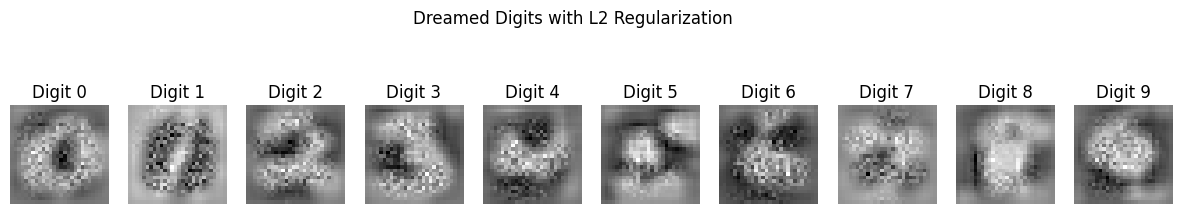

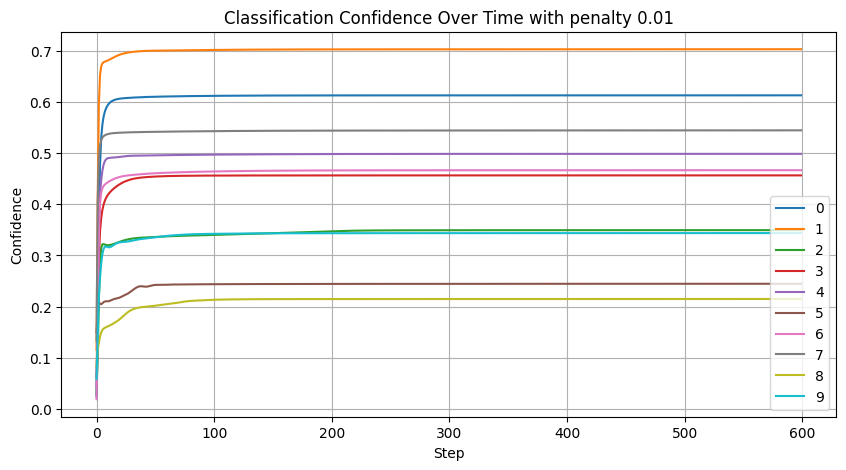

Step 0 | CE Loss: 2.6975 | L2: 0.9992 | Mean Conf: 0.0993
Step 50 | CE Loss: 0.8914 | L2: 0.6916 | Mean Conf: 0.4380
Step 100 | CE Loss: 0.8846 | L2: 0.3371 | Mean Conf: 0.4399
Step 150 | CE Loss: 0.8847 | L2: 0.2157 | Mean Conf: 0.4397
Step 200 | CE Loss: 0.8849 | L2: 0.1719 | Mean Conf: 0.4396
Step 250 | CE Loss: 0.8849 | L2: 0.1532 | Mean Conf: 0.4396
Step 300 | CE Loss: 0.8849 | L2: 0.1444 | Mean Conf: 0.4396
Step 350 | CE Loss: 0.8849 | L2: 0.1401 | Mean Conf: 0.4396
Step 400 | CE Loss: 0.8849 | L2: 0.1379 | Mean Conf: 0.4396
Step 450 | CE Loss: 0.8848 | L2: 0.1368 | Mean Conf: 0.4396
Step 500 | CE Loss: 0.8848 | L2: 0.1362 | Mean Conf: 0.4396
Step 550 | CE Loss: 0.8848 | L2: 0.1359 | Mean Conf: 0.4396
Step 599 | CE Loss: 0.8848 | L2: 0.1358 | Mean Conf: 0.4396


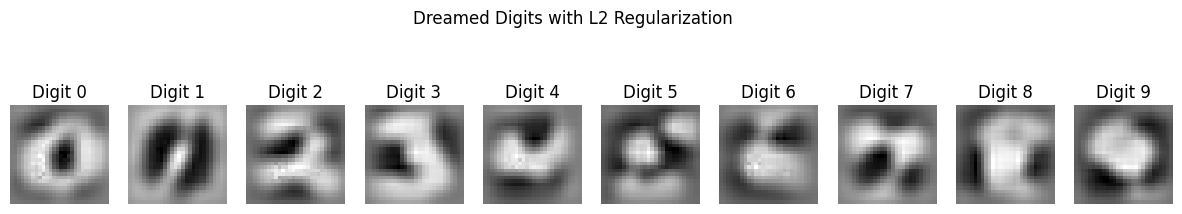

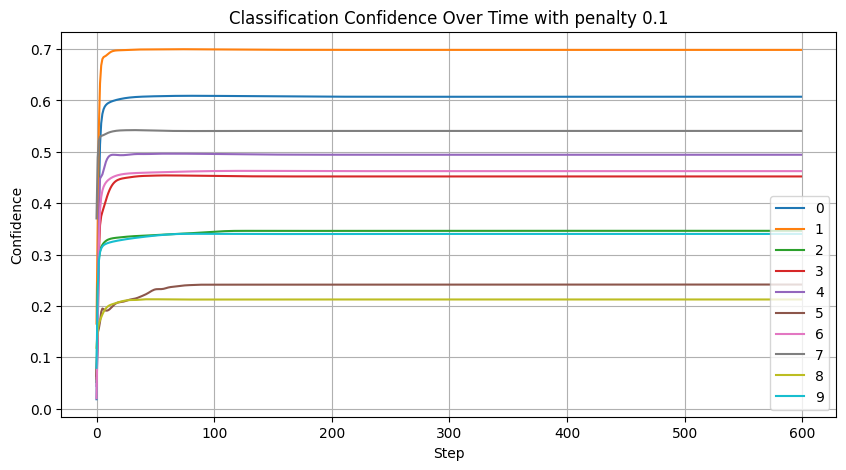

Step 0 | CE Loss: 2.8045 | L2: 0.9839 | Mean Conf: 0.0861
Step 50 | CE Loss: 0.9157 | L2: 0.0788 | Mean Conf: 0.4270
Step 100 | CE Loss: 0.9143 | L2: 0.0432 | Mean Conf: 0.4276
Step 150 | CE Loss: 0.9143 | L2: 0.0421 | Mean Conf: 0.4276
Step 200 | CE Loss: 0.9143 | L2: 0.0421 | Mean Conf: 0.4276
Step 250 | CE Loss: 0.9143 | L2: 0.0420 | Mean Conf: 0.4276
Step 300 | CE Loss: 0.9143 | L2: 0.0420 | Mean Conf: 0.4276
Step 350 | CE Loss: 0.9143 | L2: 0.0420 | Mean Conf: 0.4276
Step 400 | CE Loss: 0.9143 | L2: 0.0420 | Mean Conf: 0.4276
Step 450 | CE Loss: 0.9143 | L2: 0.0420 | Mean Conf: 0.4276
Step 500 | CE Loss: 0.9143 | L2: 0.0420 | Mean Conf: 0.4276
Step 550 | CE Loss: 0.9143 | L2: 0.0420 | Mean Conf: 0.4276
Step 599 | CE Loss: 0.9143 | L2: 0.0420 | Mean Conf: 0.4276


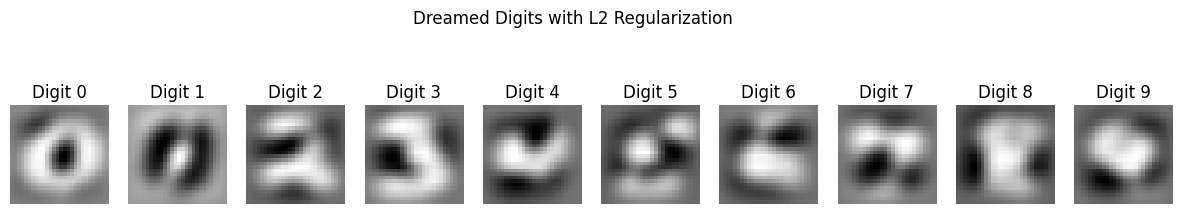

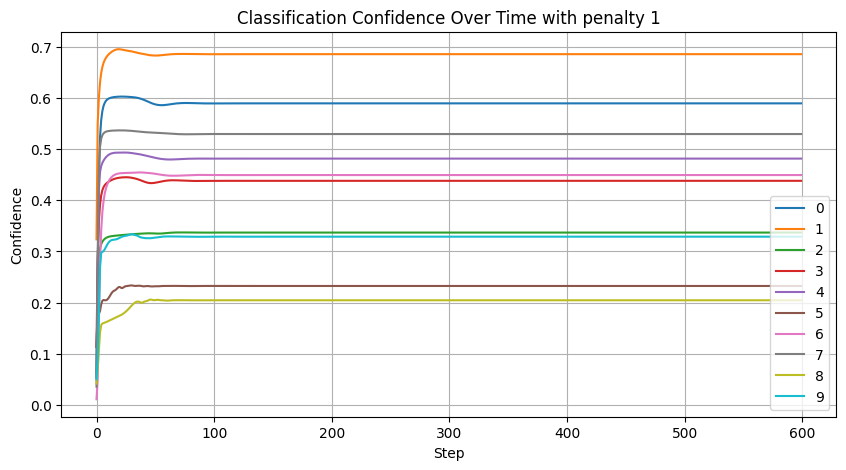

Step 0 | CE Loss: 2.6580 | L2: 1.0017 | Mean Conf: 0.1032
Step 50 | CE Loss: 1.0053 | L2: 0.0157 | Mean Conf: 0.3925
Step 100 | CE Loss: 1.0074 | L2: 0.0128 | Mean Conf: 0.3915
Step 150 | CE Loss: 1.0074 | L2: 0.0128 | Mean Conf: 0.3915
Step 200 | CE Loss: 1.0074 | L2: 0.0128 | Mean Conf: 0.3915
Step 250 | CE Loss: 1.0074 | L2: 0.0128 | Mean Conf: 0.3915
Step 300 | CE Loss: 1.0074 | L2: 0.0128 | Mean Conf: 0.3915
Step 350 | CE Loss: 1.0074 | L2: 0.0128 | Mean Conf: 0.3915
Step 400 | CE Loss: 1.0074 | L2: 0.0128 | Mean Conf: 0.3915
Step 450 | CE Loss: 1.0074 | L2: 0.0128 | Mean Conf: 0.3915
Step 500 | CE Loss: 1.0074 | L2: 0.0128 | Mean Conf: 0.3915
Step 550 | CE Loss: 1.0074 | L2: 0.0128 | Mean Conf: 0.3915
Step 599 | CE Loss: 1.0074 | L2: 0.0128 | Mean Conf: 0.3915


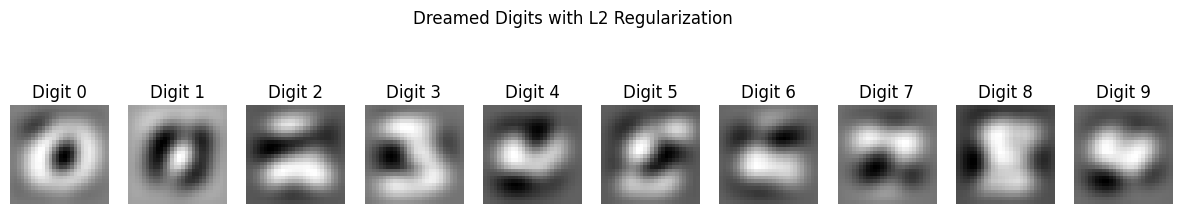

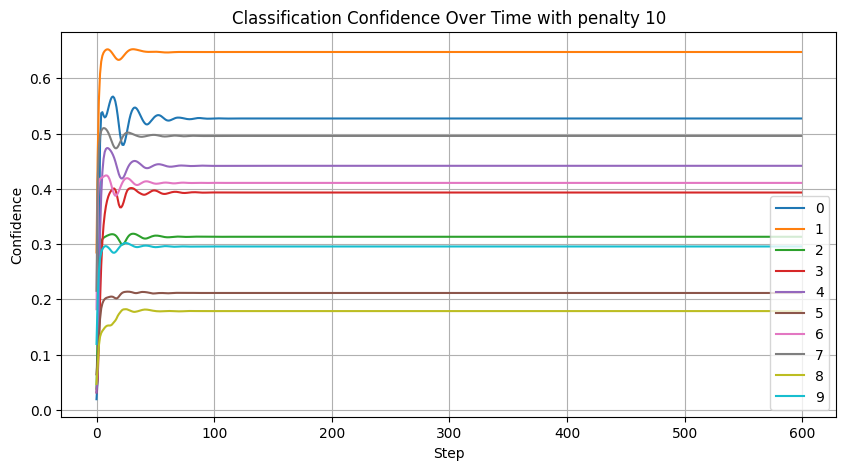

Step 0 | CE Loss: 2.6149 | L2: 1.0140 | Mean Conf: 0.1021
Step 50 | CE Loss: 1.3143 | L2: 0.0054 | Mean Conf: 0.2902
Step 100 | CE Loss: 1.3151 | L2: 0.0031 | Mean Conf: 0.2903
Step 150 | CE Loss: 1.3149 | L2: 0.0031 | Mean Conf: 0.2903
Step 200 | CE Loss: 1.3149 | L2: 0.0031 | Mean Conf: 0.2903
Step 250 | CE Loss: 1.3149 | L2: 0.0031 | Mean Conf: 0.2903
Step 300 | CE Loss: 1.3149 | L2: 0.0031 | Mean Conf: 0.2903
Step 350 | CE Loss: 1.3149 | L2: 0.0031 | Mean Conf: 0.2903
Step 400 | CE Loss: 1.3149 | L2: 0.0031 | Mean Conf: 0.2903
Step 450 | CE Loss: 1.3149 | L2: 0.0031 | Mean Conf: 0.2903
Step 500 | CE Loss: 1.3149 | L2: 0.0031 | Mean Conf: 0.2903
Step 550 | CE Loss: 1.3149 | L2: 0.0031 | Mean Conf: 0.2903
Step 599 | CE Loss: 1.3149 | L2: 0.0031 | Mean Conf: 0.2903


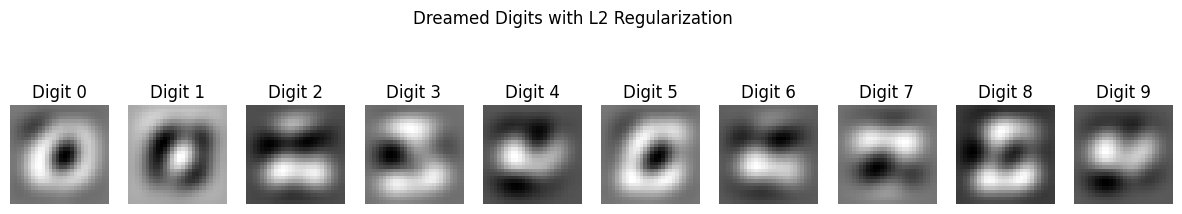

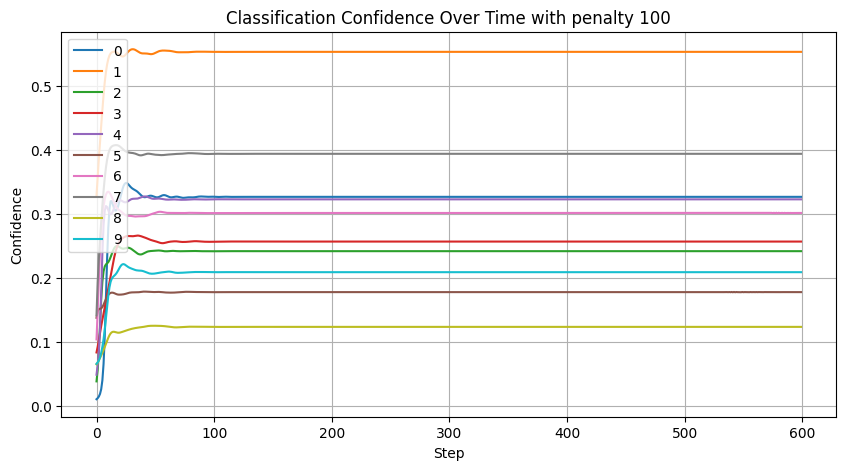

In [6]:
def plot_task3_results(images, history, lambda_l2):

    fig, axes = plt.subplots(1, 10, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
        ax.set_title(f"Digit {i}")
    plt.suptitle("Dreamed Digits with L2 Regularization")
    plt.show()


    history = np.array(history)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.plot(history[:, i], label=f"{i}")
    plt.title(f"Classification Confidence Over Time with penalty {lambda_l2}")
    plt.xlabel("Step")
    plt.ylabel("Confidence")
    plt.legend()
    plt.grid(True)
    plt.show()
    # test dla różnych kar.
for lam in [0.01, 0.1, 1, 10, 100]:
  final_images, confidence_history = dream_digits_l2(net, lambda_l2=lam)

  plot_task3_results(final_images, confidence_history, lam)

# Adwersaryjna część

In [33]:
def generate_adversarial_example(x, y_wrong, model, lambda_l2=0.01, num_steps=50, lr=0.01):

    x = x.clone().detach()
    x = x.to(device)

    delta = torch.zeros_like(x, requires_grad=True).to(device)

    # Choose a wrong target class
    y_wrong_tensor = torch.tensor([y_wrong], device=device)
    #print(y_wrong_tensor.dim())
    optimizer = torch.optim.Adam([delta], lr=lr)

    for _ in range(num_steps):
        optimizer.zero_grad()

        output = model(x + delta)
        loss = F.cross_entropy(output, y_wrong_tensor) + lambda_l2 * delta.pow(2).mean()

        loss.backward()
        optimizer.step()

        # Optional: clamp to [0, 1] valid pixel range
        delta.data = torch.clamp(x + delta.data, 0, 1) - x

    x_adv = x + delta.detach()
    return x_adv, y_wrong

# uwaga

In [23]:
for i, (x, y) in enumerate(testloader):
    if i >= examples_to_try:
        break

    x, y = x.to(device), y.to(device)
    y_true = y.item()

    for y_wrong in range(10):
        if y_wrong == y_true:
            continue  # Skip the correct class

        x_adv, _ = generate_adversarial_example(x, y_wrong, net, lambda_l2=lambda_l2)

        with torch.no_grad():
            adv_pred = net(x_adv).argmax(dim=1).item()

        success = (adv_pred == y_wrong)
        print(f'True: {y_true}, Target: {y_wrong}, Pred: {adv_pred}, Success: {success}')
        # optionally: show_images(x, x_adv, y_true, adv_pred)

ValueError: Expected input batch_size (1) to match target batch_size (0).

# koniec niepop

In [8]:
def show_images(original, adversarial, orig_pred, adv_pred, i):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(original.squeeze(), cmap='gray')
    axs[0].set_title(f'Original (Pred: {orig_pred})')
    axs[1].imshow(adversarial.squeeze(), cmap='gray')
    axs[1].set_title(f'Adversarial (Pred: {adv_pred})')
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f'Example {i}')
    plt.show()

pomoc

In [14]:
print(x.dim())
print(x.dim())

4
4


In [13]:
lambda_l2 = 0.01
examples_to_try = 10
success_count = 0

for i, (x, y) in enumerate(testloader):
    if i >= examples_to_try:
        break

    x_adv, y_wrong = generate_adversarial_example(x, y, net, lambda_l2=lambda_l2)

    with torch.no_grad():
        adv_pred = net(x_adv).argmax(dim=1).item()

    if adv_pred != y.item():
        success_count += 1

    show_images(x, x_adv, y.item(), adv_pred, i)
    print(f'True label: {y.item()}, Adv Prediction: {adv_pred}, Success: {adv_pred != y.item()}')

print(f'\nSuccess rate: {success_count / examples_to_try * 100:.2f}%')

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

koniec pomoc

Found adversarial example for True=7, Target=0


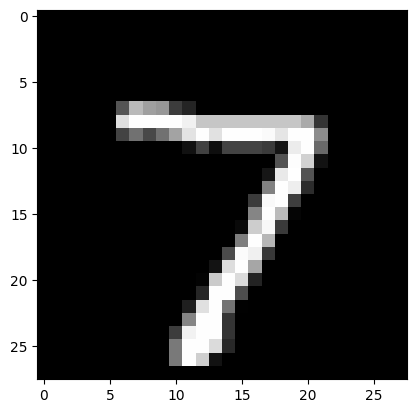

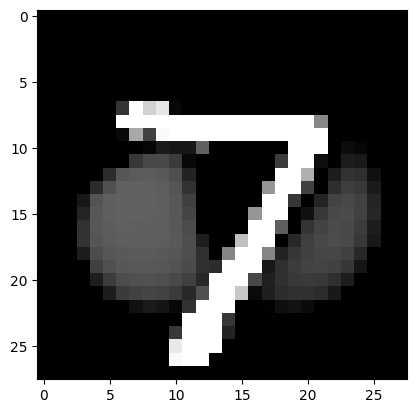

Found adversarial example for True=7, Target=2


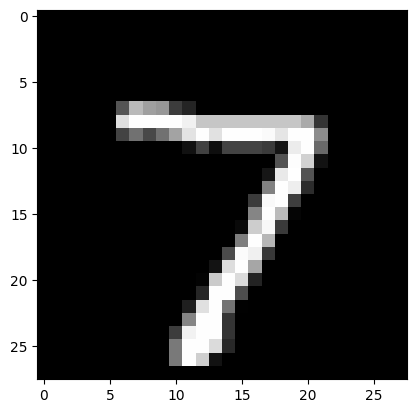

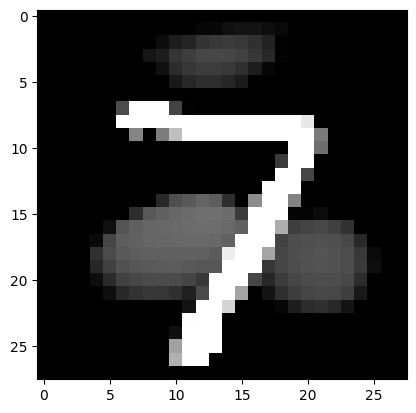

Found adversarial example for True=7, Target=3


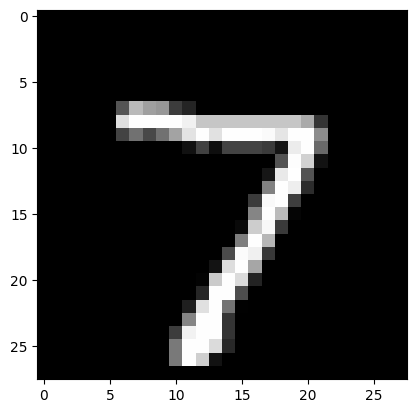

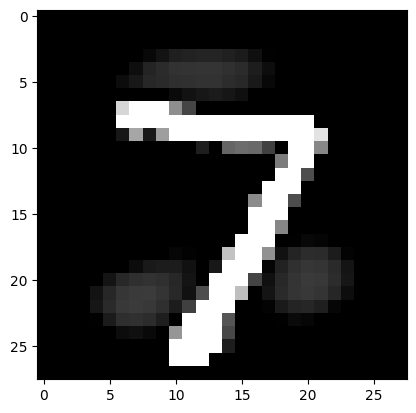

Found adversarial example for True=2, Target=0


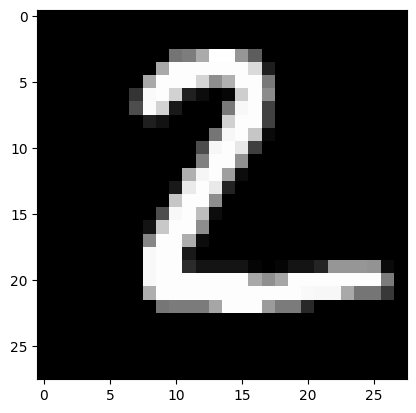

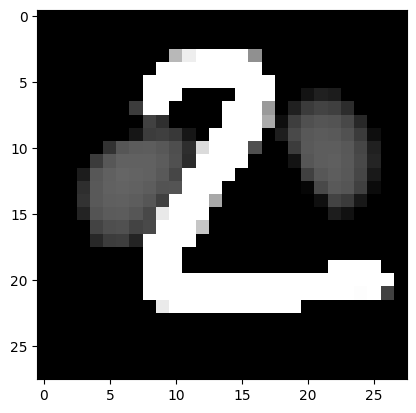

Found adversarial example for True=2, Target=3


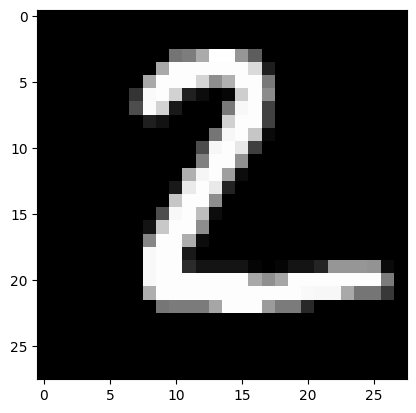

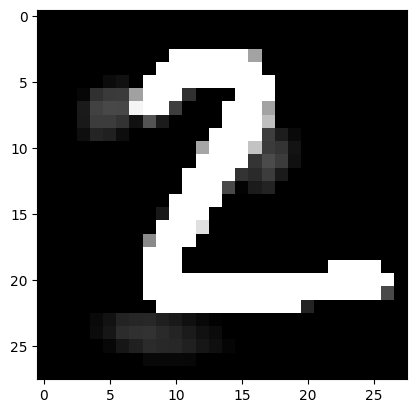

Found adversarial example for True=1, Target=0


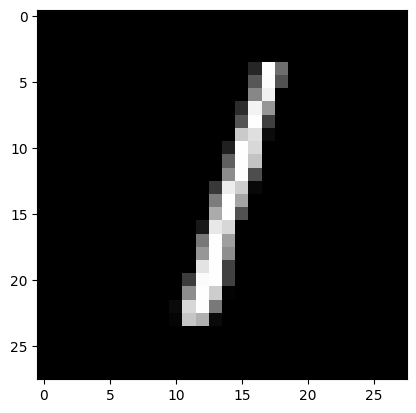

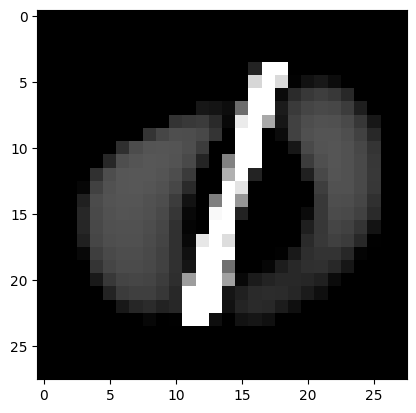

Found adversarial example for True=1, Target=2


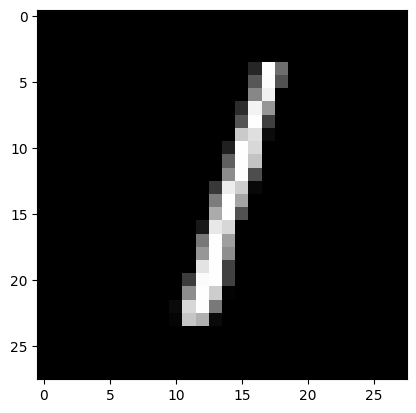

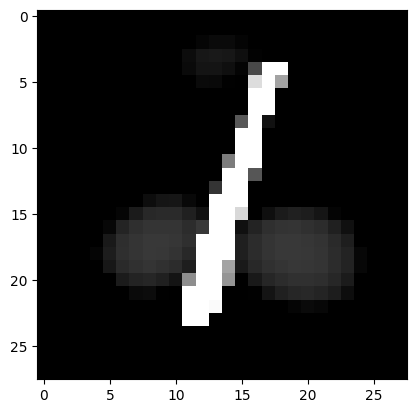

Found adversarial example for True=1, Target=3


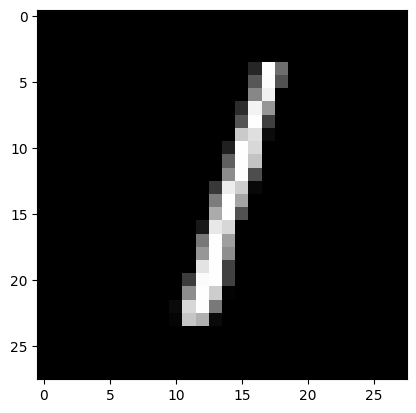

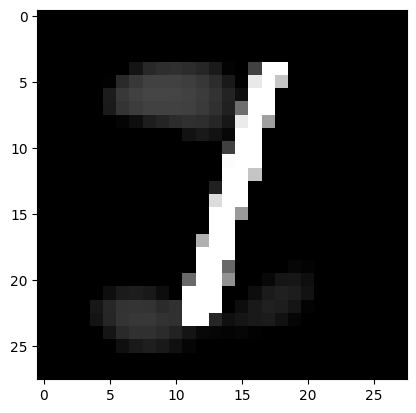

Found adversarial example for True=1, Target=4


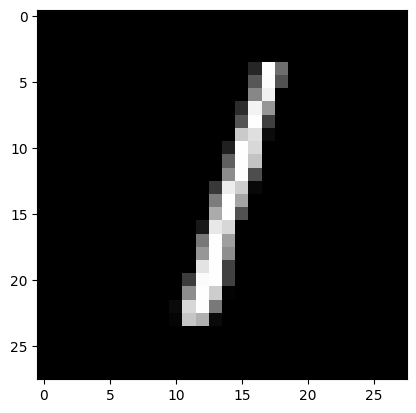

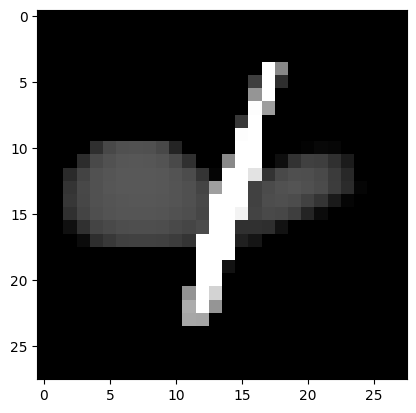

Found adversarial example for True=1, Target=5


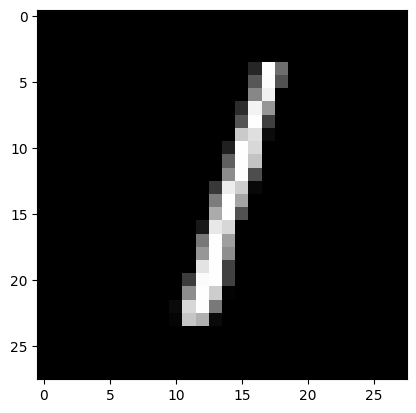

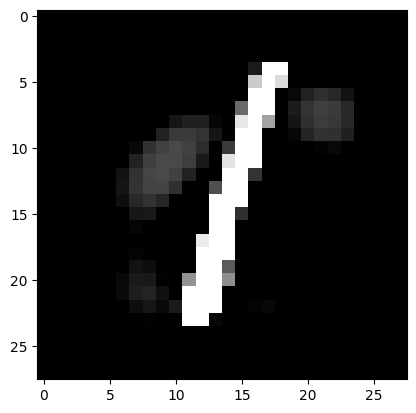

Found adversarial example for True=1, Target=6


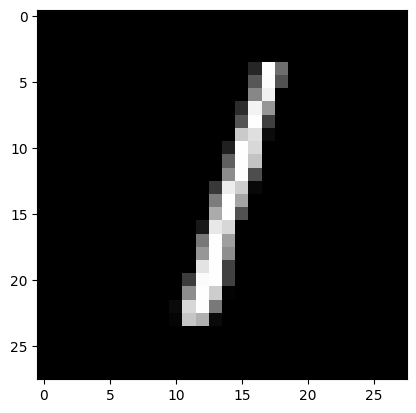

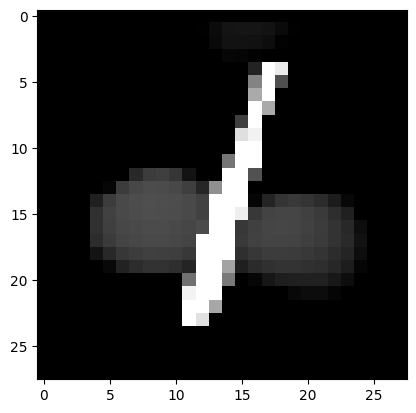

Found adversarial example for True=1, Target=7


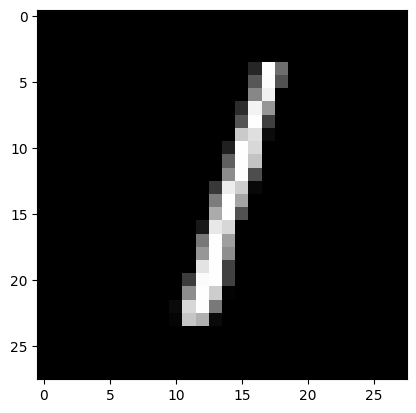

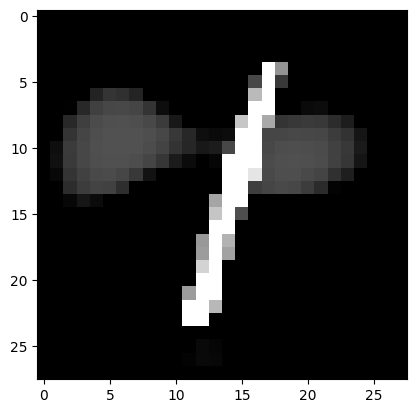

Found adversarial example for True=1, Target=9


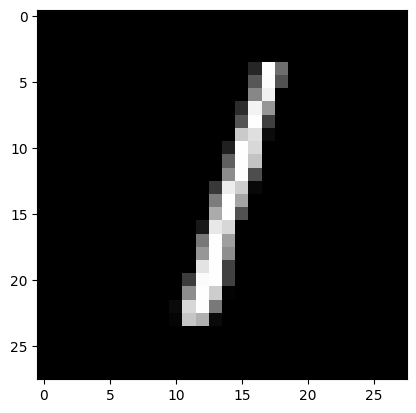

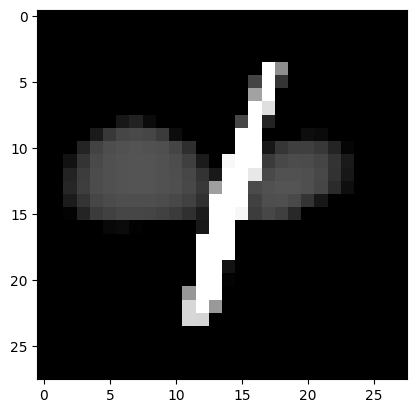

Found adversarial example for True=4, Target=0


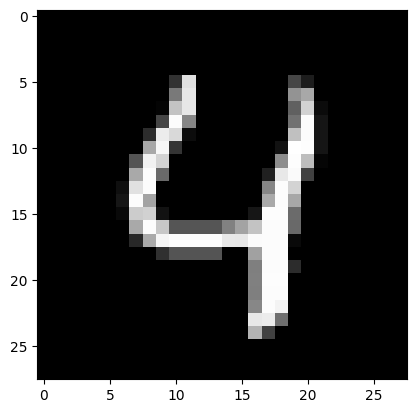

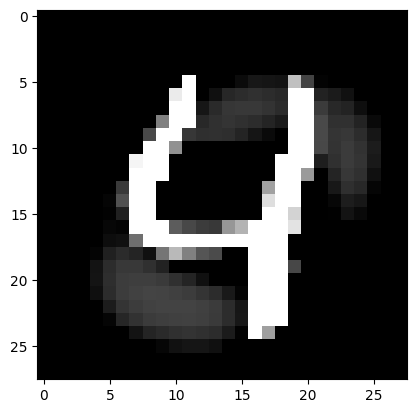

Found adversarial example for True=4, Target=3


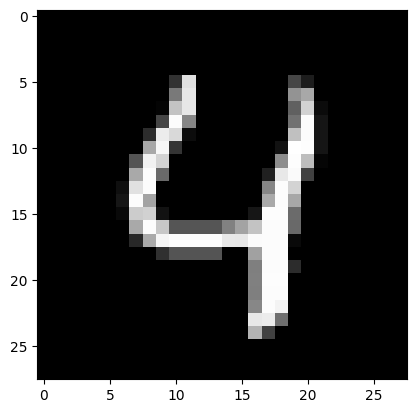

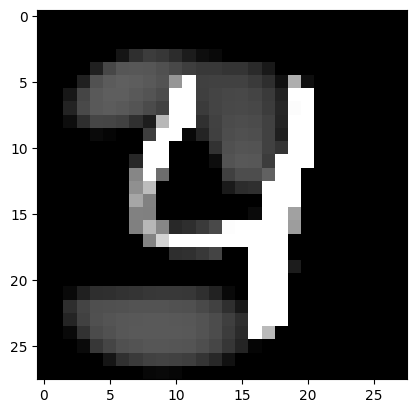

Found adversarial example for True=4, Target=6


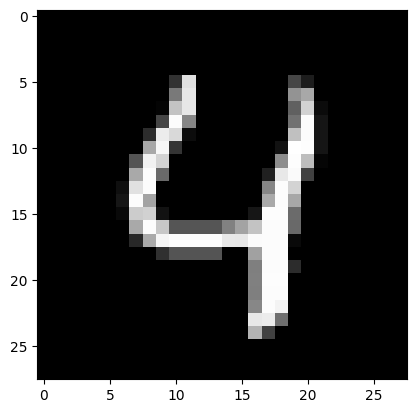

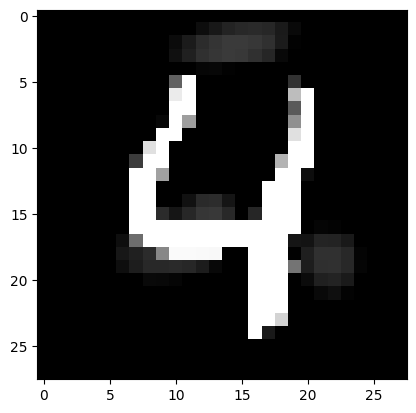

Found adversarial example for True=4, Target=2


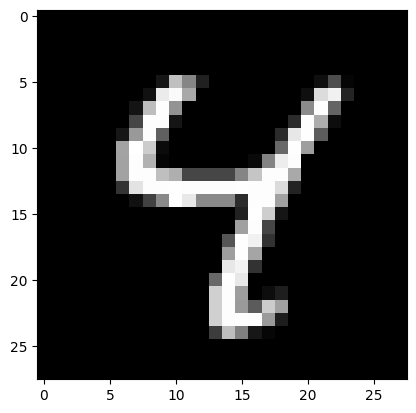

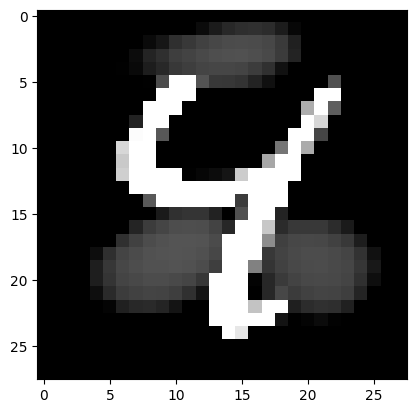

Found adversarial example for True=4, Target=5


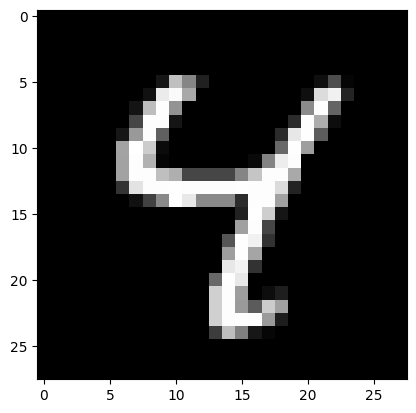

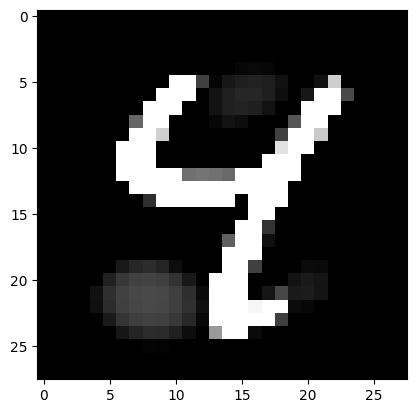

Found adversarial example for True=4, Target=7


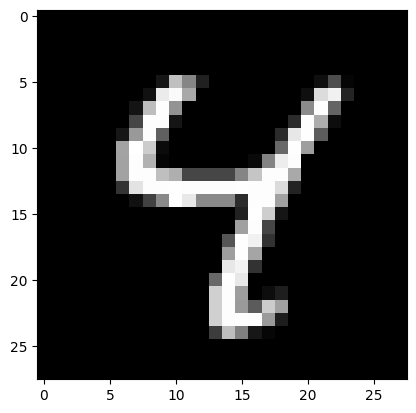

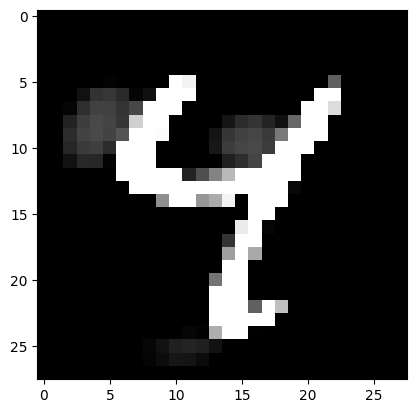

Found adversarial example for True=4, Target=8


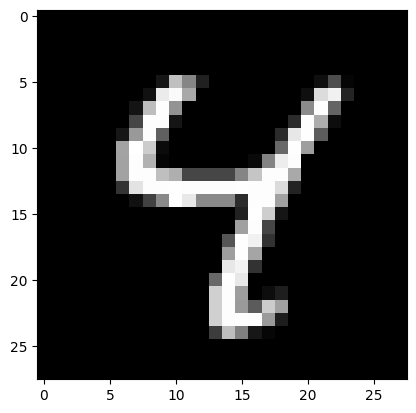

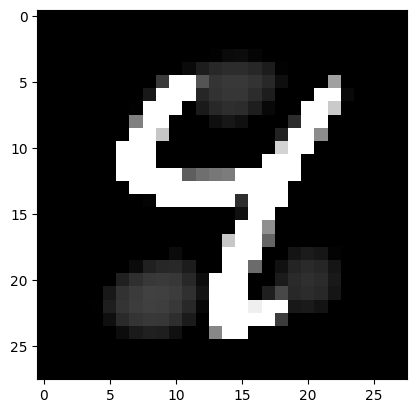

Found adversarial example for True=4, Target=9


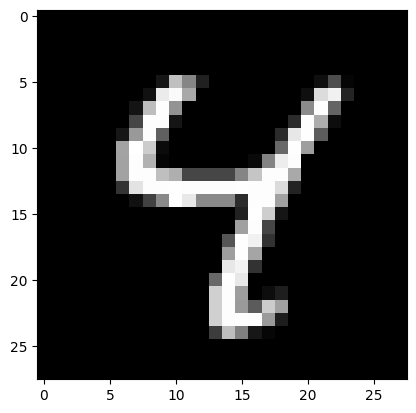

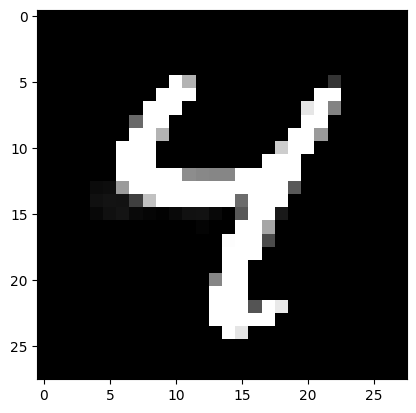

Found adversarial example for True=9, Target=0


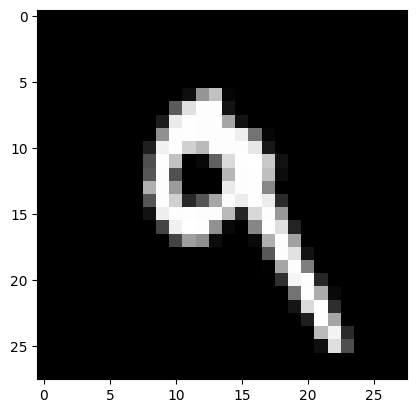

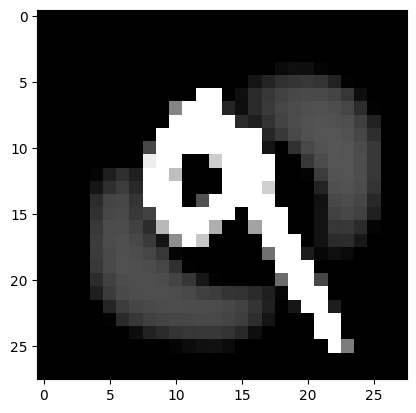

Found adversarial example for True=9, Target=3


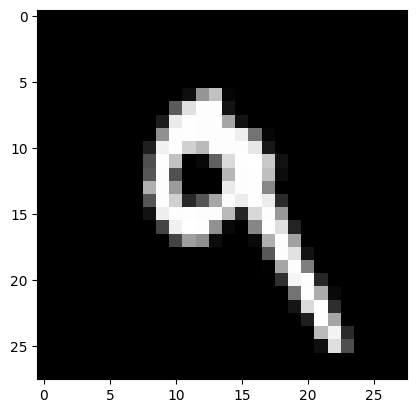

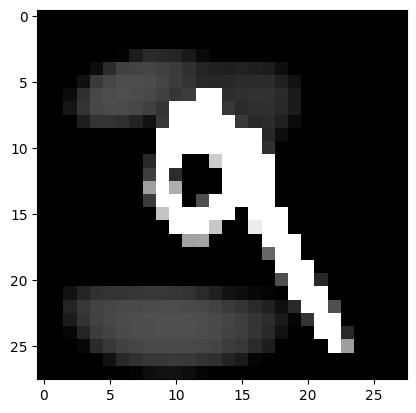

Found adversarial example for True=9, Target=4


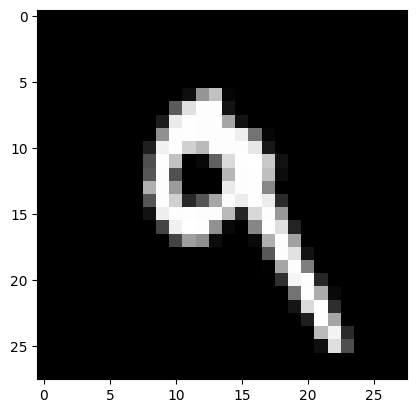

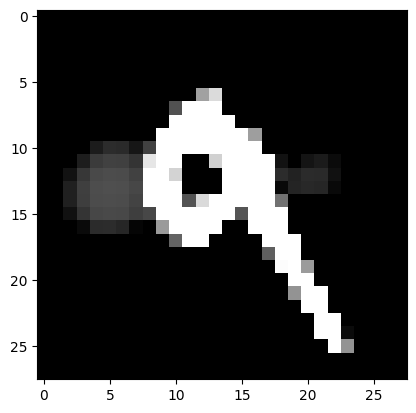

Found adversarial example for True=9, Target=6


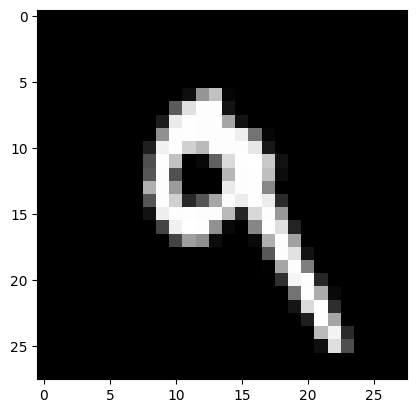

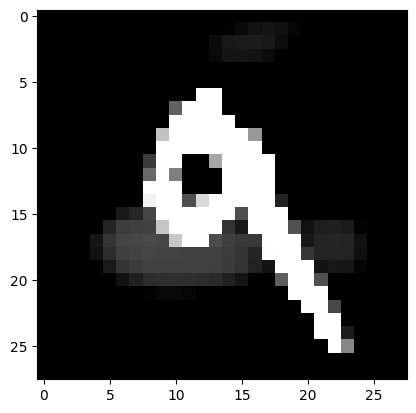

Found adversarial example for True=9, Target=8


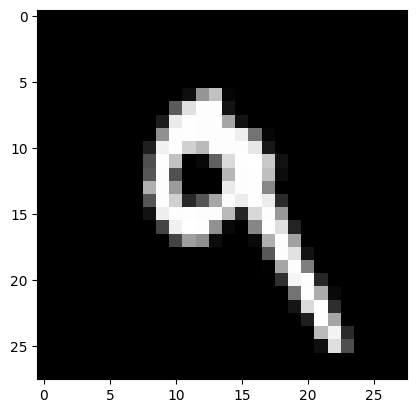

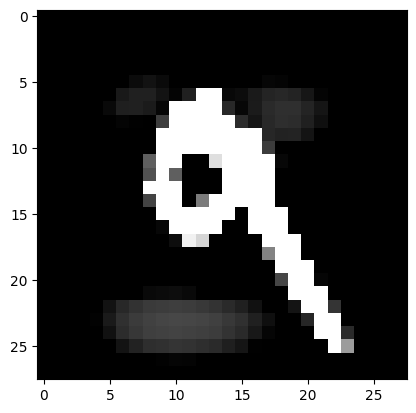

Found adversarial example for True=5, Target=0


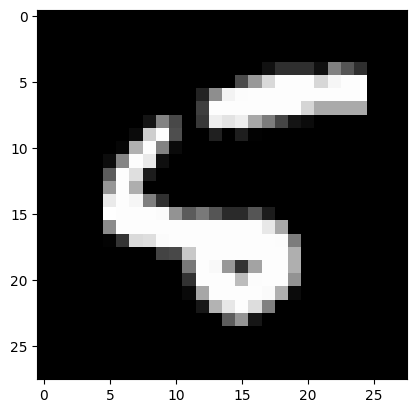

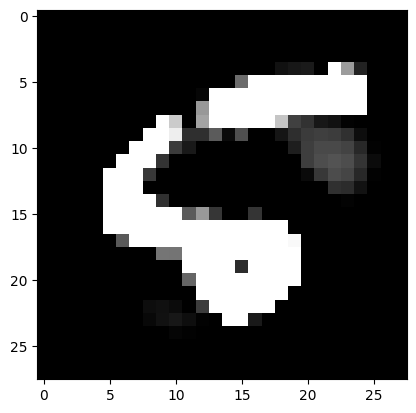

Found adversarial example for True=9, Target=7


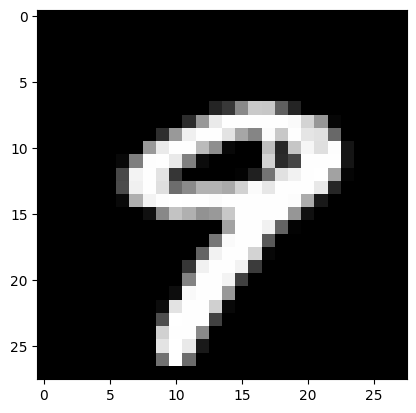

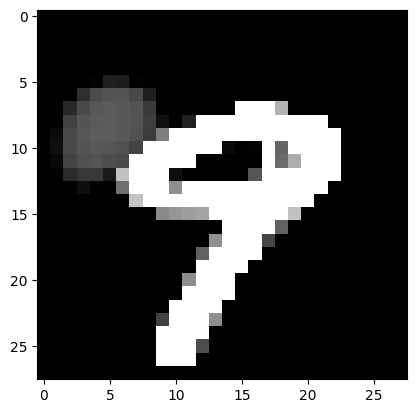

Found adversarial example for True=6, Target=0


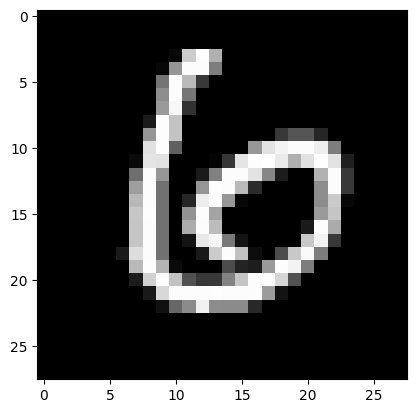

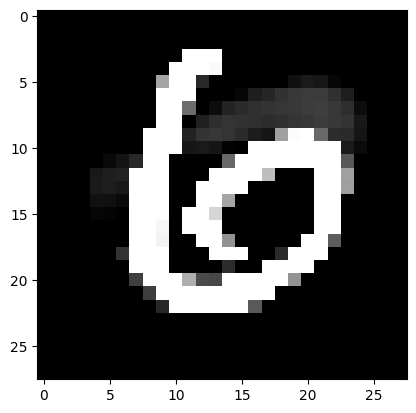

Found adversarial example for True=9, Target=2


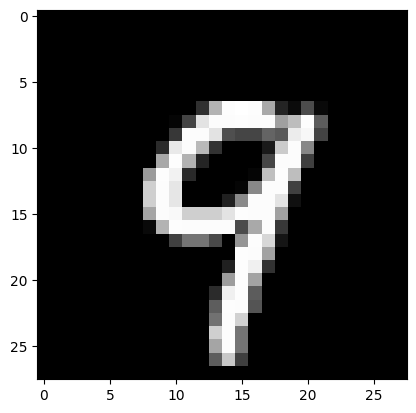

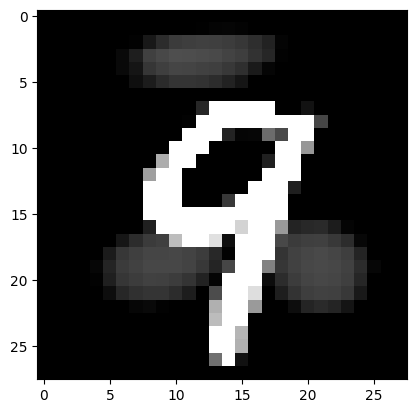

In [42]:
lambda_l2 = 10
found_pairs = set()  # To track completed (y_true, y_wrong) pairs
max_per_pair = 1     # Just one example per (true, target) pair

for i, (x, y) in enumerate(testloader):
    y_true = y.item()
    x = x.to(device)
    y = y.to(device)

    for y_wrong in range(10):
        if y_wrong == y_true:
            continue

        pair = (y_true, y_wrong)
        if pair in found_pairs:
            continue  # Already done this pair

        # Run adversarial generation
        x_adv, _ = generate_adversarial_example(x, y_wrong, net, lambda_l2=lambda_l2)

        with torch.no_grad():
            adv_pred = net(x_adv).argmax(dim=1).item()

        if adv_pred == y_wrong:
            found_pairs.add(pair)
            print(f"Found adversarial example for True={y_true}, Target={y_wrong}")

            # Optional: Save or show the image
            plt.imshow(x.squeeze().detach().cpu().numpy(), cmap='gray')
            plt.show()
            plt.imshow(x_adv.squeeze().detach().cpu().numpy(), cmap='gray')
            plt.show()
            # save_image(x_adv, f"adv_{y_true}_to_{y_wrong}.png")

        # Stop early if all 90 pairs are collected
        if len(found_pairs) >= 30:
            break

    if len(found_pairs) >= 30:
        break